In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta

In [2]:
ru_idices_meta = pd.read_csv(os.path.join("..", "data", "indices", "indices_meta.csv"))

In [3]:
ru_idices_meta

,Тикер,Описание,N компаний,TR брутто,Наличие ETF,дата base,дата TR,Расчетная капа млрд руб
0,MOEXBMI,широкий рынок,100,нет,нет,2011,NaN,6996
1,IMOEX,примерно топ 50,43,MCFTR,оба,1997,2004.0,6219
2,MCXSM,средняя и малая капа,54,MESMTR,есть TR,2012,2013.0,688
3,MOEXCN,потреб сектор,18,MECNTR,есть TR,2004,2013.0,181
4,MOEXFN,фин сектор,13,MEFNTR,есть TR,2004,2013.0,383
5,MOEXOG,нефтегаз,11,MEOGTR,нет,2004,2013.0,1983
6,MOEXEU,электроэнергия,14,MEEUTR,нет,2004,2013.0,125
7,MOEXTL,телеком,4,METLTR,нет,2004,2013.0,16
8,MOEXMM,металлы и добыча,15,MEMMTR,нет,2004,2013.0,570
9,MOEXCH,химия,5,MECHTR,нет,2006,2013.0,127


In [8]:
ru_idices_meta.iloc[3:]['N компаний'].sum()

np.int64(97)

In [ ]:
def reshape_and_calc_returns(df, price_col='Close', resample_factor='W-FRI'):
    s = df[price_col]
    df_reshaped = pd.DataFrame()

    df_reshaped['Price'] = s.resample(resample_factor).last()

    df_reshaped['Return'] = df_reshaped['Price'].pct_change()

    df_reshaped['Log Return'] = np.log(df_reshaped['Prices']).diff()

    return df_reshaped

def calc_rolling_volatility(df, return_col='Return', window=4):
    df_vol = pd.DataFrame()
    df_vol['Rolling Volatility'] = df[return_col].rolling(window=window).std() * np.sqrt(window)
    return df_vol

In [ ]:
base_dir = os.path.join("..", "data", "indices")

def read_and_process_indices(indices_meta):
    bm_index_df = pd.read_csv(os.path.join(base_dir, f"{indices_meta.iloc[0]["Тикер"]}.csv"), parse_dates=["Date"], index_col="Date")  

    base_main_index = pd.read_csv(os.path.join(base_dir, f"{indices_meta.iloc[1]["Тикер"]}.csv"), parse_dates=["Date"], index_col="Date")  
    tr_main_index = pd.read_csv(os.path.join(base_dir, f"{indices_meta.iloc[1]["TR брутто"]}.csv"), parse_dates=["Date"], index_col="Date")  

    sm_index = pd.read_csv(os.path.join(base_dir, f"{indices_meta.iloc[2]["Тикер"]}.csv"), parse_dates=["Date"], index_col="Date")
    tr_sm_index = pd.read_csv(os.path.join(base_dir, f"{indices_meta.iloc[2]["TR брутто"]}.csv"), parse_dates=["Date"], index_col="Date")
    
    base_industry_indices_dfs = {}
    tr_industry_indices_dfs = {}
    for ind, row in ru_idices_meta.iloc[3:].iterrows():
        industry = row["Описание"]
        
        base_index = row['Тикер']
        tr_index = row['TR брутто']
        
        base_index_path = os.path.join(base_dir, f"{base_index}.csv")
        base_industry_indices_dfs[industry] = pd.read_csv(base_index_path, parse_dates=["Date"], index_col="Date")

        tr_index_path = os.path.join(base_dir, f"{tr_index}.csv")
        tr_industry_indices_dfs[industry] = pd.read_csv(tr_index_path, parse_dates=["Date"], index_col="Date")

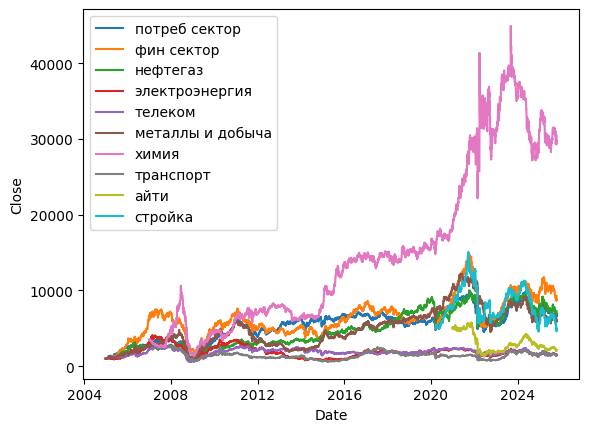

In [5]:
for key in base_indices_dfs.keys():
    sns.lineplot(data=base_indices_dfs[key]['Close'], label=key)

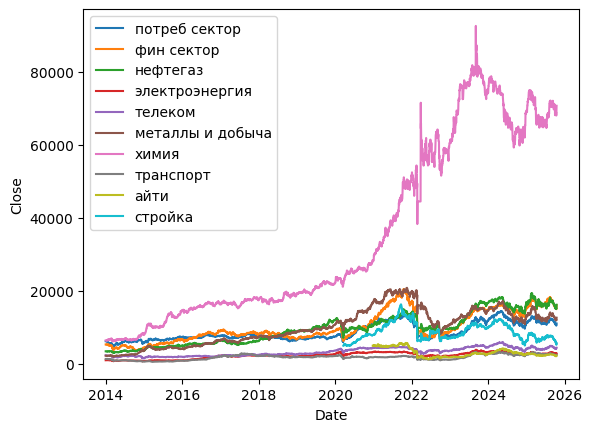

In [6]:
for key in tr_indices_dfs.keys():
    sns.lineplot(data=tr_indices_dfs[key]['Close'], label=key)

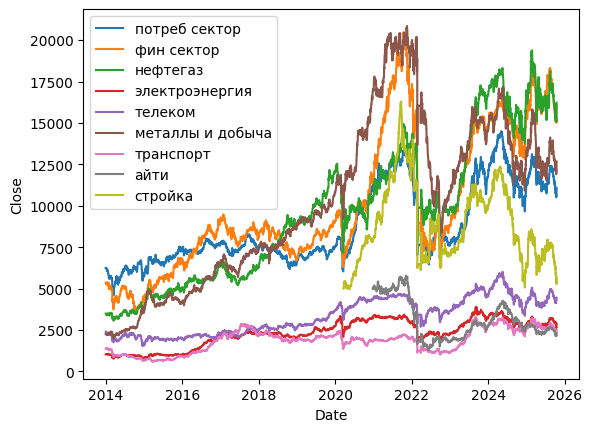

In [7]:
for key in tr_indices_dfs.keys():
    if key != "химия":
        sns.lineplot(data=tr_indices_dfs[key]['Close'], label=key)

In [ ]:
calendar_days_per_year = 365.25
weeks_per_year = calendar_days_per_year / 7.0  # ≈ 52.1786 (calendar-based)

def calc_geom_annual_return(df: pd.DataFrame) -> pd.DataFrame:
    s = df['Close']

    start_price, end_price = float(s.iloc[0]), float(s.iloc[-1])
    total_factor = end_price / start_price

    start_date, end_date = s.index[0], s.index[-1]
    rd = relativedelta(end_date, start_date)
    years_float = rd.years + rd.months/12 + rd.days/calendar_days_per_year   # fractional approx
    
    return total_factor ** (1 / years_float) - 1.0

def calc_simple_annual_return(df: pd.DataFrame) -> pd.DataFrame:
    s = df['Close']

    start_price, end_price = float(s.iloc[0]), float(s.iloc[-1])
    total_return = (end_price - start_price) / start_price

    start_date, end_date = s.index[0], s.index[-1]
    rd = relativedelta(end_date, start_date)
    years_float = rd.years + rd.months/12 + rd.days/calendar_days_per_year   # fractional approx
    
    return total_return / years_float

def calc_annual_stddev(df: pd.DataFrame) -> pd.DataFrame:
    s = df['Close']
    anchor = 'W-FRI'  # use Friday as week anchor
    weekly_prices = s.resample(anchor).last()

    weekly_returns = weekly_prices.pct_change().dropna()
    weekly_stddev = weekly_returns.std()
    annualized_stddev_simple = weekly_stddev * (weeks_per_year ** 0.5)

    weekly_log_returns = (weekly_prices / weekly_prices.shift(1)).apply(lambda x: pd.np.log(x)).dropna()
    weekly_log_stddev = weekly_log_returns.std()
    annualized_stddev_log = weekly_log_stddev * (weeks_per_year ** 0.5)
    # daily_returns = s.pct_change().dropna()
    return annualized_stddev_simple, annualized_stddev_log
    

In [9]:
print(list(tr_indices_dfs.keys())[0])
test_df = tr_indices_dfs[list(tr_indices_dfs.keys())[0]]
print(calc_geom_annual_return(test_df))
print(calc_simple_annual_return(test_df))

потреб сектор
0.0498018100118629
0.06562621158269476


In [18]:
print(calc_annual_stddev(test_df))

0.22363021037441722


In [31]:
weeks_per_year

52.17857142857143

In [53]:
def calc_returns_and_show(s, anchor: str) -> pd.DataFrame:
    tmp_df = pd.DataFrame()

    tmp_df['Prices'] = s.resample(anchor).last()

    tmp_df['Returns'] = tmp_df['Prices'].pct_change()

    tmp_df['Log Returns'] = np.log(tmp_df['Prices']).diff()

    # display(tmp_df)

    return tmp_df

In [54]:
weekly_df = calc_returns_and_show(test_df['Close'], 'W-FRI')
weekly_df

,Prices,Returns,Log Returns
Date,,,
2014-01-03,6245.95,NaN,NaN
2014-01-10,6098.66,-0.023582,-0.023864
2014-01-17,6080.85,-0.002920,-0.002925
2014-01-24,5875.69,-0.033739,-0.034321
2014-01-31,5644.79,-0.039298,-0.040091
...,...,...,...
2025-09-19,11611.25,-0.024499,-0.024804
2025-09-26,11489.95,-0.010447,-0.010502
2025-10-03,10969.64,-0.045284,-0.046341


In [84]:
import seaborn as sns

In [86]:
weekly_df['Log Returns'].dropna().mean()

np.float64(0.0009322413927006479)

<Axes: xlabel='Log Returns', ylabel='Count'>

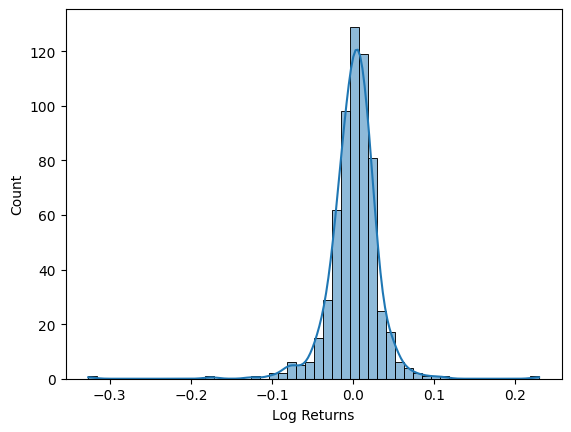

In [85]:
sns.histplot(weekly_df['Log Returns'].dropna(), kde=True)

In [55]:
yearly_df = calc_returns_and_show(test_df['Close'], 'YE')
yearly_df

,Prices,Returns,Log Returns
Date,,,
2013-12-31,6245.95,NaN,NaN
2014-12-31,5739.22,-0.081129,-0.084610
2015-12-31,7420.80,0.292998,0.256964
2016-12-31,7719.77,0.040288,0.039498
2017-12-31,7398.79,-0.041579,-0.042468
2018-12-31,6641.46,-0.102359,-0.107985
2019-12-31,7538.71,0.135098,0.126719
2020-12-31,11329.69,0.502869,0.407376
2021-12-31,11915.91,0.051742,0.050448


In [61]:
np.exp(yearly_df['Log Returns'].sum())

np.float64(1.7741624572723138)

In [62]:
yearly_df['Prices'][-1]/yearly_df['Prices'][0]

C:\Users\koles\AppData\Local\Temp\ipykernel_17576\2482153921.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yearly_df['Prices'][-1]/yearly_df['Prices'][0]


np.float64(1.7741624572723125)

In [56]:
print(weekly_df['Returns'].dropna().std() * np.sqrt(weeks_per_year))
print(weekly_df['Log Returns'].dropna().std() * np.sqrt(weeks_per_year))

0.22363021037441722
0.22792740347291965


In [58]:
print(yearly_df['Returns'].dropna().std())
print(yearly_df['Log Returns'].dropna().std())

0.26070840871449374
0.24200709966881576


In [59]:
print(yearly_df['Returns'].iloc[1:-1].std())
print(yearly_df['Log Returns'].iloc[1:-1].std())

0.2714811505902493
0.2527786678653944


$r_i = \frac{P_i}{P_{i-1}} - 1$

$
P_{n} = P_{0} * (1 + r_1) * \dots * (1 + r_n) = P_0 * (1 + \frac{P_1}{P_0} - 1) * \dots * (1 + \frac{P_n}{P_{n-1}} - 1) =
P_0 * \frac{P_1}{P_0} * \dots * \frac{P_n}{P_{n-1}}
$

$\frac{P_n}{P_0} = (1 + r_1) * \dots * (1 + r_n)$

---

$g_i = log(\frac{P_i}{P_{i-1}}) = log(P_i) - log(P_{i-1})$

$e^{g_i} = \frac{P_i}{P_{i-1}} = r_i + 1$

$g_i = log(r_i + 1)$

$log(\frac{P_n}{P_0}) = log(\frac{P_1}{P_0}*\dots*\frac{P_n}{P_{n-1}}) = log(\frac{P_1}{P_0}) + \dots + log(\frac{P_n}{P_{n-1}}) = g_1 + \dots + g_n = $

$= log(P_1) - log_(P_0) + \dots + log(P_n) - log(P_{n-1}) = log(P_n) - log(P_0)$

In [82]:
x = (120/100) ** (1/4) - 1
x

0.04663513939210562

In [83]:
(1 + x) ** 4

1.2000000000000002

In [77]:
s = pd.Series([
    100,
    110,
    90,
    120
])
df = pd.DataFrame()
df['Prices'] = s
df['Prices prev'] = df['Prices'].shift(1)
df['Div'] = df['Prices'] / df['Prices prev']
df['Log Div'] = np.log(df['Div'])
df['Returns'] = df['Div'] - 1.0
df['Log Prices'] = np.log(df['Prices'])
df['Log Prices prev'] = df['Log Prices'].shift(1)
df['Log minus'] = df['Log Prices'] - df['Log Prices prev']

In [78]:
df

,Prices,Prices prev,Div,Log Div,Returns,Log Prices,Log Prices prev,Log minus
0,100,NaN,NaN,NaN,NaN,4.605170,NaN,NaN
1,110,100.0,1.100000,0.095310,0.100000,4.700480,4.60517,0.095310
2,90,110.0,0.818182,-0.200671,-0.181818,4.499810,4.70048,-0.200671
3,120,90.0,1.333333,0.287682,0.333333,4.787492,4.49981,0.287682


In [10]:
end = test_df.index[-1]
start = test_df.index[0]
rd = relativedelta(end, start)
years_float = rd.years + rd.months/12 + rd.days/365.25   # fractional approx

In [11]:
years_float

11.796543463381246

In [12]:
rd.years

11

In [ ]:
analytics_df = pd.DataFrame()
for key in base_indices_dfs.keys():
    b_df = base_indices_dfs[key]
    tr_df = tr_indices_dfs[key]
    
    # Calculate geometric mean returns
    

    base_std = b_df['Close'].std()
    tr_std = tr_df['Close'].std() 
    